In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv("train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#Sex(性別)、Embarked(乗船場所)は、ダミー変数化

sex_dum = pd.get_dummies(df_train['Sex'])
df_train_proc = pd.concat((df_train,sex_dum),axis=1)
df_train_proc = df_train_proc.drop('Sex',axis=1)
df_train_proc = df_train_proc.drop('female',axis=1)

emb_dum = pd.get_dummies(df_train['Embarked'])
df_train_proc = pd.concat((df_train_proc,emb_dum),axis=1)
df_train_proc = df_train_proc.drop('Embarked',axis=1)
df_train_proc = df_train_proc.drop('S',axis=1)

In [3]:
#データの欠損値確認
df_train.isnull().sum()
#cabin, ageの欠損値多い

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
#データ欠損値除外、乗客ID、NAME、チケットNo、船室
df_train_proc_dn = df_train_proc.dropna()
df_train_proc_dn = df_train_proc_dn.drop('PassengerId',axis=1)
df_train_proc_dn = df_train_proc_dn.drop('Name',axis=1)
df_train_proc_dn = df_train_proc_dn.drop('Ticket',axis=1)
df_train_proc_dn = df_train_proc_dn.drop('Cabin',axis=1)
 
df_train_proc_dn.corr()
#生存は性別がもっとも相関が高く、ついで年齢が高い

,Survived,Pclass,Age,SibSp,Parch,Fare,male,C,Q
Survived,1.000000,-0.037227,-0.244604,0.100339,0.018723,0.134019,-0.535727,0.098712,-0.039232
Pclass,-0.037227,1.000000,-0.307590,-0.100324,0.049894,-0.315069,-0.041725,-0.228001,-0.038676
Age,-0.244604,-0.307590,1.000000,-0.161625,-0.274813,-0.091542,0.172307,0.076824,0.017855
SibSp,0.100339,-0.100324,-0.161625,1.000000,0.258993,0.285492,-0.095344,-0.050628,0.169778
Parch,0.018723,0.049894,-0.274813,0.258993,1.000000,0.388783,-0.081832,-0.068949,-0.065543
Fare,0.134019,-0.315069,-0.091542,0.285492,0.388783,1.000000,-0.129871,0.239531,0.015604
male,-0.535727,-0.041725,0.172307,-0.095344,-0.081832,-0.129871,1.000000,-0.053879,-0.002826
C,0.098712,-0.228001,0.076824,-0.050628,-0.068949,0.239531,-0.053879,1.000000,-0.076941
Q,-0.039232,-0.038676,0.017855,0.169778,-0.065543,0.015604,-0.002826,-0.076941,1.000000


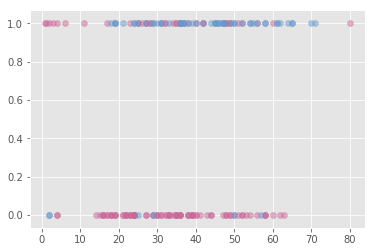

In [5]:
#性別と年齢ごとの生存を可視化。※x軸が年齢、y軸が性別（1=男性、0=女性）、赤色のプロットが生存、青色のプロットが死亡
import seaborn as sns
plt.style.use('ggplot')

df_train_sur = df_train_proc_dn[df_train_proc_dn.Survived==1]
df_train_sur_age = df_train_sur.iloc[:,2]
df_train_sur_s = df_train_sur.iloc[:,6]
plt.scatter(df_train_sur_age,df_train_sur_s,color="#cc6699",alpha=0.5)

df_train_sur = df_train_proc_dn[df_train_proc_dn.Survived==0]
df_train_sur_age = df_train_sur.iloc[:,2]
df_train_sur_s = df_train_sur.iloc[:,6]
plt.scatter(df_train_sur_age,df_train_sur_s,color="#6699cc",alpha=0.5)

plt.show()
#女性の方が優先的に救助されている（y=0：女性において、赤い点が多い）、男性の中(y=1)でも、若年層は多く生存してい

In [6]:
#年齢をどうやって補完するか、非構造化データのうち”敬称””苗字（家族名）”に注目
#”mr”、”master”、”miss”、”mrs”が主にあり、それぞれ年齢に関係あり
#検証・自分と自分を除く家族の間での、生存の相関：0.41・2人以上で乗船した家族において、”全員生存、あるいは死亡”した割合：58%

In [7]:
#名前データから、”mr”,”master”,”mrs”,”miss”のフラグを抽出

def name_classifier(name_df):    
    name_class_df = pd.DataFrame(columns={'miss','mrs','master','mr'})
    
    for name in name_df:        
        if 'Miss' in name:
            df = pd.DataFrame([[1,0,0,0]],columns={'miss','mrs','master','mr'})
        elif 'Mrs' in name:
            df = pd.DataFrame([[0,1,0,0]],columns={'miss','mrs','master','mr'})
        elif 'Master' in name:
            df = pd.DataFrame([[0,0,1,0]],columns={'miss','mrs','master','mr'})
        elif 'Mr' in name:
            df = pd.DataFrame([[0,0,0,1]],columns={'miss','mrs','master','mr'})
        else :
            df = pd.DataFrame([[0,0,0,0]],columns={'miss','mrs','master','mr'})
        name_class_df = name_class_df.append(df,ignore_index=True)        
    return name_class_df


In [8]:
#名前データから、家族名を抽出し、そこから家族の(自分以外の)生存率を計算

name_df_train = df_train.iloc[:,3]
survive_array = df_train.iloc[:,1]

name_df = name_df_train

name_array = []
name_count = []
name_survive_count = []
name_survive_ratio = []

name_i = 0

for name in name_df:   
    name_split = name.split(" ")
    name_split_first = name_split[0].replace(',','')
    if name_split_first in name_array:
        name_count[name_array.index(name_split_first)] = name_count[name_array.index(name_split_first)] + 1
        name_survive_count[name_array.index(name_split_first)] = name_survive_count[name_array.index(name_split_first)] + survive_array[name_i]                            
    else:
        name_array.append(name_split_first)
        name_count.append(1)
        name_survive_count.append(survive_array[name_i])
    name_i = name_i + 1
        
count = 0
for i in name_count:
    if name_count[count] == 1:
        name_survive_ratio.append(0)
    else:
        name_survive_ratio.append(name_survive_count[count]/(name_count[count]))
    count = count + 1
    
survive_ratio_array = []    

for name in name_df:
    name_split = name.split(" ")
    name_split_first = name_split[0].replace(',','')
    survive_ratio_array.append(name_survive_ratio[name_array.index(name_split_first)])

survive_ratio_array

[0.0,
 0,
 0,
 0.5,
 0.5,
 0.33333333333333331,
 0,
 0.0,
 0.5,
 0.5,
 1.0,
 0,
 0,
 0.22222222222222221,
 0,
 0,
 0.0,
 0.25,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0.75,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0.33333333333333331,
 0.5,
 0,
 0,
 0.0,
 1.0,
 0,
 0.0,
 0,
 0.66666666666666663,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0.0,
 0,
 0.75,
 0,
 0,
 0,
 0,
 0,
 0.66666666666666663,
 0.0,
 0,
 0,
 0.5,
 0.0,
 0,
 1.0,
 0,
 0,
 0.22222222222222221,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0.0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 1.0,
 0.5,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0,
 0,
 0.33333333333333331,
 0,
 0.0,
 0,
 0.33333333333333331,
 0.0,
 0,
 0,
 0.0,
 0.5,
 0.22222222222222221,
 0.0,
 0,
 0.5,
 0.5,
 0.0,
 1.0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0.0,
 0,
 0.5,
 0,
 0,
 0,
 0.22222222222222221,
 0.0,
 0.66666666666666663,
 0,
 0,
 0.5,
 0,
 0.0,
 0.0,
 0.25,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0.0,
 0.0,
 0.66666666666666663,
 0

In [9]:
#敬称によって分けられたフラグ別に、k-近傍法で年齢を推計補完（近い属性の人の年齢を参考にして年齢を補完）

def estimate_age_by_distance(train_df):
    perfect_df = train_df.dropna()
    perfect_df_master = perfect_df[perfect_df.master==1]
    perfect_df_mr = perfect_df[perfect_df.mr==1]
    perfect_df_mrs = perfect_df[perfect_df.mrs==1]
    perfect_df_miss = perfect_df[perfect_df.miss==1]
    perfect_df_other = perfect_df.query("master==0 and mr==0 and mrs==0 and miss==0")

    est_age_df = pd.DataFrame(columns={'est_age'})
    
    for row in range(0,len(train_df)):
        df = train_df.iloc[row]
        distance_list = []

        if df.Age > 0:
            est_age = pd.DataFrame([[df.Age]],columns={'est_age'})
        else:
            if df.master == 1:
                for p_row in range(0,len(perfect_df_master)):
                    df2 = perfect_df_master.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_master,df,df2)
                    distance_list.append([df2.Age,distance])                                                        
            elif df.mr == 1:
                for p_row in range(0,len(perfect_df_mr)):
                    df2 = perfect_df_mr.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_mr,df,df2)
                    distance_list.append([df2.Age,distance])                                    

            elif df.mrs == 1:
                for p_row in range(0,len(perfect_df_mrs)):
                    df2 = perfect_df_mrs.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_mrs,df,df2)
                    distance_list.append([df2.Age,distance])                                    
            elif df.miss == 1:
                for p_row in range(0,len(perfect_df_miss)):
                    df2 = perfect_df_miss.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_miss,df,df2)
                    distance_list.append([df2.Age,distance])                                    
            else:
                for p_row in range(0,len(perfect_df_other)):
                    df2 = perfect_df_other.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_other,df,df2)
                    distance_list.append([df2.Age,distance])                                                    
                    
            distance_list.sort(key=lambda x: x[1])          
            sum_age = 0
            avg_age = 0

            for k in range(0,3):
                sum_age = sum_age + distance_list[k][0]
            avg_age = sum_age / 3    
            est_age = pd.DataFrame([[avg_age]],columns={'est_age'})                
        est_age_df = est_age_df.append(est_age,ignore_index=True)        

    return est_age_df

In [10]:
#PipelineでX_train2_sur、y_train2_sur正規化する必要ある

In [11]:
from sklearn.svm import SVC

best_score = 0.7986
for i in range(5,20):
    i = i / 100    
    for j in range(100,250):
        j = j / 100
        clf_svm = SVC(kernel='rbf',random_state=0,gamma=i,C=j)
        pipe_svm = Pipeline([['sc', StandardScaler()],['clf', clf_svm]])
        scores = cross_val_score(estimator=clf_svm,
                                 X=X_train2_sur,
                                 y=y_train2_sur,
                                 cv=10,
                                 scoring='roc_auc')
        if scores.mean() > best_score:
            print("gamma:",i,"C:",j,scores.mean(),"+-",scores.std())

NameError: name 'Pipeline' is not defined